______________________________________
# <center>**Trabajo Practico Nº2 para la Materia *Organización de Datos***</center>

*Integrantes*:
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022

Datos provistos por [properati](https://www.properati.com.ar).
______________________________________


## Introducción

El presente trabajo práctico es una continuación del ‘TP1: Propiedades en Venta’. 

En la entrega anterior se propuso aplicar técnicas de análisis exploratorio, preprocesamiento de datos, agrupamiento, clasificación y regresión. Siguiendo esta línea, y con el objetivo de continuar resolviendo problemas reales de ciencia de datos, en esta segunda parte se implementarán nuevos modelos predictivos a partir de los anteriormente mencionados. 

En esta oportunidad se buscará demostrar los conocimientos adquiridos sobre procesamiento del lenguaje natural, redes neuronales y ensamble de modelos. Para esto se utilizarán tanto datasets provistos por la materia, tomados de la página de la empresa Properati, como los generados por el grupo en el trabajo anterior.

## 0. Setup

### Importación de bibliotecas

In [ ]:
pip install visualkeras scikeras[tensorflow] scikeras[tensorflow-cpu] unidecode types-all tensorflow keras

In [3]:
#Importación de librerías

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from xgboost import XGBRegressor
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from collections import Counter
import unidecode
import re
from joblib import load, dump
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from collections import defaultdict
import math
from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasClassifier
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
import joblib
#Configuración de Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Ejecución con Drive
if 'google.colab' in str(get_ipython()):
    IN_COLAB = True
else:
    IN_COLAB = False

if IN_COLAB :
    from google.colab import drive
    drive.mount('/content/drive')

    df_train = pd.read_csv('/content/drive/MyDrive/Orga/DATASETS/df_train_tp1.csv')
    df_test = pd.read_csv('/content/drive/MyDrive/Orga/DATASETS/df_test_tp1.csv')
    properati_descrip = pd.read_csv('/content/drive/MyDrive/Orga/DATASETS/properati_argentina_2021_decrip.csv')
    stop_words = '/content/drive/MyDrive/Orga/stopwords.txt'
else:
    df_train = pd.read_csv('./DATASETS/df_train_tp1.csv')
    df_test = pd.read_csv('./DATASETS/df_test_tp1.csv')
    properati_descrip = pd.read_csv('properati_argentina_2021_decrip.csv')
    stop_words = 'stopwords'

Mounted at /content/drive


### Funciones auxiliares

In [4]:
def metricas_clasificacion(y_test, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_test, y_pred, average="macro"),2)}')
    print(f'Recall: {round(recall_score(y_test, y_pred, average="macro"),2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_pred, average="macro"),2)}')

In [5]:
def prediccion_y_metricas_regresion(regressor, x_test, y_test):

  y_pred = regressor.predict(x_test)

  print(f"Se obtuvo un Score de {round(regressor.score(x_test, y_test)*100,3)}%")

  mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

  print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

  rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

  print(f"El error según la métrica 'Root Mean Square Error' de test es: {rmse}")

  return

In [6]:
def format_aspects(line, word):
    format = r"\W*([\w]+)"
    n = 2
    x = re.search(r'{}\W*{}{}'.format(format*n, word, format*n), line)
    if x is not None:
        return x.group()
    else:
        return ""

In [7]:
def convert_b_m_a(x):
    mx = max(x[0], x[1], x[2])
    if mx == x[0]:
        return 'bajo'
    elif mx == x[1]:
        return 'medio'
    elif mx == x[2]:
        return 'alto'

In [8]:
def estandarizar(df, columns):
  sscaler = StandardScaler()

  for col in columns:
    df[col] = sscaler.fit_transform(pd.DataFrame(df[col]))

In [9]:
def limpiar_values_de_aspects(df, aspects, values):
    i = 0
    for aspect in aspects:
        for word in values[i]:
            df[aspect] = df[aspect].apply(lambda line: word if word in line else line)
        df[aspect] = df[aspect].apply(lambda line: line if len(line.split())<2 else '')
        i = i+1

In [10]:
def evaluate_model(model, x, y, splits, n):
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=n, random_state=1)
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [11]:
import plotly.graph_objects as go

def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Error Cuadrático Medio',
    showlegend=False)
    fig.show()

### Preparación de datasets

In [12]:
df_train_x = df_train.drop(["property_price", "tipo_precio_3"], axis="columns")
df_train_y_regresion = df_train["property_price"]
df_train_y_clasificacion = df_train["tipo_precio_3"]

df_test_x = df_test.drop(["property_price", "tipo_precio_3"], axis="columns")
df_test_y_regresion = df_test["property_price"]
df_test_y_clasificacion = df_test["tipo_precio_3"]

## 1. Procesamiento del Lenguaje Natural

### 1.a Ampliación del dataset
___

Hacemos un merge del dataset original y el de descripciones, y quedémonos únicamente con las columnas `id` y `property_description`:

In [73]:
df_descrip = pd.merge(df_train_x, properati_descrip, on="id")
df_descrip = df_descrip[["id", "property_description"]]

df_test_descrip = pd.merge(df_test_x, properati_descrip, on="id")
df_test_descrip = df_test_descrip[["id", "property_description"]]

Busquemos aspectos de una propiedad utilizando la columna `property_description`.

Veamos cuántos registros nulos existen:

In [74]:
print(f"Hay {df_descrip['property_description'].isna().sum()} datos nulos.")

Hay 0 datos nulos.


Veamos cuáles son las 100 palabras más comunes en el campo de descripción de propiedades:

In [75]:
Counter(" ".join(df_descrip["property_description"]).split()).most_common(100)

[('de', 857976),
 ('y', 507778),
 ('con', 401867),
 ('la', 290195),
 ('en', 278176),
 ('a', 243751),
 ('el', 169952),
 ('del', 153279),
 ('que', 140055),
 ('por', 133635),
 ('al', 125215),
 ('-', 113875),
 ('un', 103716),
 ('las', 90713),
 ('los', 88435),
 ('para', 88190),
 ('se', 63109),
 ('DE', 56457),
 ('son', 56420),
 ('2', 52790),
 ('es', 50384),
 ('una', 48927),
 ('3', 41258),
 ('cocina', 38889),
 ('ambientes', 38848),
 ('valor', 38420),
 ('esta', 38292),
 ('muy', 36893),
 ('x', 36800),
 ('Av.', 36630),
 ('comedor', 35535),
 ('baño', 35476),
 ('Y', 34141),
 ('CON', 33915),
 ('no', 33912),
 ('piso', 33348),
 ('o', 33050),
 ('/', 32253),
 ('tu', 32101),
 ('A', 32063),
 ('hasta', 30269),
 ('balcón', 29805),
 ('inmueble', 28725),
 ('casa', 28655),
 ('No', 28635),
 ('propiedad.', 28070),
 ('30%', 27684),
 ('departamento', 27670),
 ('EN', 27267),
 ('cuadras', 27069),
 ('Corredor', 26991),
 ('préstamo', 26920),
 ('cuota', 26780),
 ('medidas', 26422),
 ('Responsable:', 25970),
 ('living'

Podemos observar que podríamos optimizar el texto mediante algunas técnicas de reducción y/o transformación. Entre otras:

Eliminemos la etiqueta `<br>` de html:

In [76]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: line.replace("<br>", " "))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: line.replace("<br>", " "))

Transformemos todas las palabras a minúsculas, de modo que el contador no realice distinciones:

In [77]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: line.lower())
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: line.lower())


Quitemos los tíldes de las letras:

In [78]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: unidecode.unidecode(line))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: unidecode.unidecode(line))

Eliminemos los símbolos:

In [79]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: re.sub(r'[^\w]', ' ', line))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: re.sub(r'[^\w]', ' ', line))

Eliminemos los espacios múltiples entre palabras:

In [80]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: re.sub("\s\s+" , " ", line))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: re.sub("\s\s+" , " ", line))

Utilizando el contenido del archivo `stop_words.txt`, eliminemos palabras sin significado del datset y colocamos los cambios en uno nuevo:

In [81]:
with open(stop_words) as f:
    lines = f.read().splitlines()

f = lambda x: ' '.join([item for item in x.split() if item not in lines])

df_descrip["property_description"] = df_descrip["property_description"].apply(f)
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(f)

Luego de estas transformaciones, veamos cuáles son las palabras más utilizadas:

In [82]:
Counter(" ".join(df_descrip["property_description"]).split()).most_common(100)

[('cocina', 89458),
 ('2', 88203),
 ('bano', 74428),
 ('3', 74274),
 ('ambientes', 71516),
 ('balcon', 71288),
 ('comedor', 68490),
 ('piso', 67830),
 ('living', 63837),
 ('propiedad', 62558),
 ('departamento', 54476),
 ('edificio', 53422),
 ('av', 50583),
 ('1', 50142),
 ('dormitorio', 48859),
 ('completo', 48391),
 ('pisos', 46212),
 ('4', 46043),
 ('frente', 44713),
 ('expensas', 44286),
 ('n', 44023),
 ('excelente', 41314),
 ('corredor', 41145),
 ('medidas', 41046),
 ('x', 40904),
 ('inmueble', 40569),
 ('responsable', 37723),
 ('amplio', 36355),
 ('m2', 34044),
 ('30', 34027),
 ('placard', 33948),
 ('casa', 32676),
 ('dormitorios', 32257),
 ('lavadero', 31877),
 ('c', 31791),
 ('cuadras', 31165),
 ('luminoso', 30549),
 ('cucicba', 30414),
 ('accede', 29382),
 ('terraza', 29328),
 ('ley', 27849),
 ('aire', 27700),
 ('lendar', 27449),
 ('queres', 27416),
 ('prestamo', 27366),
 ('vista', 26980),
 ('venta', 26867),
 ('cuota', 26856),
 ('podes', 26580),
 ('salida', 26111),
 ('ubicacion

Seleccionemos los aspectos que nos parecen relevantes, para luego buscar sus posibles valores.

Para esto, elegimos: `cocina`, `pisos`, `calefaccion`, `expensas`, `lavadero`, `balcon`, `cochera` y `aire` y limpiamos cualquier tipo de formato restante en el dataset:

In [83]:
aspectos = ['cocina', 'pisos', 'calefaccion', 'expensas', 'lavadero', 'balcon', 'cochera', 'aire']

In [84]:
for word in aspectos:
    df_descrip[word] = df_descrip["property_description"].apply(lambda line: format_aspects(line, word))
    df_test_descrip[word] = df_test_descrip["property_description"].apply(lambda line: format_aspects(line, word))

Veamos cuáles son las 15 palabras más comunes para cada uno de los aspectos elegidos:

In [85]:
cant_val_aspectos = 15

#### Aspecto `cocina`

In [86]:
Counter(" ".join(df_descrip["cocina"]).split()).most_common(cant_val_aspectos)

[('cocina', 62810),
 ('comedor', 19198),
 ('integrada', 11530),
 ('living', 9979),
 ('bano', 8949),
 ('lavadero', 6978),
 ('balcon', 6225),
 ('independiente', 6077),
 ('completo', 5385),
 ('diario', 4992),
 ('muebles', 4829),
 ('separada', 4746),
 ('amplia', 4518),
 ('toilette', 3963),
 ('completa', 3692)]

Para `cocina`, los valores podrían ser: 
- integrada
- lavadero
- completa

#### Aspecto `pisos`

In [87]:
Counter(" ".join(df_descrip["pisos"]).split()).most_common(cant_val_aspectos)

[('pisos', 31829),
 ('parquet', 6394),
 ('madera', 4426),
 ('porcelanato', 4025),
 ('living', 3671),
 ('edificio', 3624),
 ('comedor', 3155),
 ('unidades', 1821),
 ('cocina', 1754),
 ('departamentos', 1662),
 ('bano', 1576),
 ('2', 1411),
 ('4', 1314),
 ('3', 1241),
 ('ambientes', 1201)]

Para `pisos`, los valores podrían ser: 
- porcelanato
- parquet
- madera

#### Aspecto `calefaccion`

In [88]:
Counter(" ".join(df_descrip["calefaccion"]).split()).most_common(cant_val_aspectos)

[('calefaccion', 15449),
 ('radiante', 4448),
 ('losa', 3916),
 ('central', 3444),
 ('caliente', 2653),
 ('agua', 2257),
 ('radiadores', 2052),
 ('individual', 1921),
 ('aire', 1777),
 ('piso', 1527),
 ('caldera', 1246),
 ('tiro', 1197),
 ('acondicionado', 1097),
 ('servicios', 1056),
 ('ambientes', 798)]

Para `calefaccion`, los valores podrían ser: 
- radiadores
- radiante
- central
- individual

#### Aspecto `expensas`

In [89]:
Counter(" ".join(df_descrip["expensas"]).split()).most_common(cant_val_aspectos*2)

[('expensas', 35164),
 ('servicios', 6846),
 ('impuestos', 5906),
 ('valores', 5559),
 ('bajas', 4879),
 ('funcionales', 4365),
 ('000', 3296),
 ('abl', 2445),
 ('medidas', 1959),
 ('aysa', 1606),
 ('sujetos', 1542),
 ('propiedad', 1276),
 ('superficies', 1260),
 ('indicados', 1242),
 ('consignadas', 1189),
 ('2021', 1147),
 ('tasas', 1143),
 ('mensuales', 1138),
 ('consignado', 1084),
 ('gastos', 1053),
 ('presente', 1046),
 ('ambientes', 1044),
 ('sujeto', 947),
 ('500', 942),
 ('edificio', 915),
 ('aprox', 867),
 ('4', 836),
 ('incluyen', 829),
 ('2', 819),
 ('3', 806)]

Para `expensas`, los valores podrían ser: 
- servicios
- impuestos 
- bajas

#### Aspecto `lavadero`

In [90]:
Counter(" ".join(df_descrip["lavadero"]).split()).most_common(cant_val_aspectos)

[('lavadero', 28549),
 ('independiente', 7972),
 ('cocina', 7923),
 ('comedor', 4376),
 ('bano', 4342),
 ('diario', 3175),
 ('servicio', 2922),
 ('dependencia', 2920),
 ('incorporado', 2506),
 ('completo', 2102),
 ('patio', 1882),
 ('separado', 1807),
 ('balcon', 1738),
 ('espacio', 1736),
 ('toilette', 1385)]

Para `lavadero`, los valores podrían ser: 
- independiente
- cocina
- comedor

#### Aspecto `balcon`

In [91]:
Counter(" ".join(df_descrip["balcon"]).split()).most_common(cant_val_aspectos)

[('balcon', 42917),
 ('salida', 9996),
 ('frente', 9711),
 ('comedor', 8052),
 ('ambientes', 6387),
 ('corrido', 6126),
 ('cocina', 4569),
 ('living', 4207),
 ('vista', 4051),
 ('amplio', 3716),
 ('terraza', 3682),
 ('aterrazado', 3172),
 ('2', 3151),
 ('luminoso', 2855),
 ('3', 2684)]

Para `balcon`, los valores podrían ser: 
- frente
- amplio 
- terraza 
- salida 
- corrido
- luminoso

#### Aspecto `cochera`

In [92]:
Counter(" ".join(df_descrip["cochera"]).split()).most_common(cant_val_aspectos*2)

[('cochera', 17208),
 ('cocheras', 7359),
 ('fija', 4756),
 ('cubierta', 4118),
 ('ambientes', 3484),
 ('baulera', 2863),
 ('2', 2467),
 ('edificio', 2119),
 ('balcon', 1521),
 ('3', 1399),
 ('opcional', 1307),
 ('1', 1132),
 ('fijas', 1080),
 ('terraza', 1007),
 ('dependencia', 979),
 ('posibilidad', 958),
 ('piso', 826),
 ('frente', 780),
 ('bano', 760),
 ('disponibles', 759),
 ('departamento', 759),
 ('4', 753),
 ('servicio', 729),
 ('planta', 701),
 ('parrilla', 699),
 ('espacio', 615),
 ('subsuelo', 598),
 ('amenities', 586),
 ('completo', 553),
 ('patio', 525)]

Para `cochera`, los valores podrían ser: 
- fija
- cubierta

#### Aspecto `aire`

In [93]:
Counter(" ".join(df_descrip["aire"]).split()).most_common(cant_val_aspectos)

[('aire', 20578),
 ('acondicionado', 14337),
 ('frio', 5985),
 ('aires', 5809),
 ('split', 2204),
 ('ciudad', 2020),
 ('acondicionados', 1961),
 ('luz', 1851),
 ('equipos', 1585),
 ('calefaccion', 1493),
 ('instalacion', 1413),
 ('ambientes', 1411),
 ('living', 1138),
 ('central', 1062),
 ('balcon', 1002)]

Para `aire`, posibles valores son: 
- split 
- central 
- acondicionado

#### Consolidación de valores

A continuación creamos la variable `values`, que contiene los posibles valores para cada uno de los aspectos elegidos:

In [94]:
values_cocina = ['integrada' , 'lavadero' , 'completa']
values_pisos = ['porcelanato' , 'parquet' , 'madera']
values_calefaccion = ['radiadores' , 'radiante' , 'central' , 'individual']
values_expensas = ['serviocios' , 'impuestos' , 'bajas']
values_lavadero = ['independiente' , 'cocina' , 'comedor']
values_balcon = ['frente' , 'amplio' , 'terraza' , 'salida' , 'corrido' , 'luminoso']
values_cochera = ['fija' , 'cubierta']
values_aire = ['split' , 'central' , 'acondicionado']

In [95]:
values = [values_cocina, values_pisos, values_calefaccion, values_expensas, values_lavadero, values_balcon, values_cochera, values_aire]

En primer lugar, creamos un dataset auxiliar que tenga los IDs y las columnas de los aspectos:

In [96]:
aux_df = df_descrip.copy()
aux_df_test = df_test_descrip.copy()

aux_df.drop('property_description', inplace=True, axis=1)
aux_df_test.drop('property_description', inplace=True, axis=1)

Luego creamos una función a la que -pasándole un dataset, los aspectos y el listado de valores posibles- reemplace el contenido de las columnas por los valores correspondientes.

Modificamos las columnas de los aspectos, para que sólo queden los valores correspondientes:

In [97]:
limpiar_values_de_aspects(aux_df, aspectos, values)
limpiar_values_de_aspects(aux_df_test, aspectos, values)

Por último hacemos el merge con el dataset original, teniendo en cuenta los IDs:

In [98]:
df = df_train_x.copy()
df = pd.merge(df,aux_df, on="id")
df.drop("id", inplace=True, axis="columns")

df_test = df_test_x.copy()
df_test = pd.merge(df_test,aux_df_test, on="id")
df_test.drop("id", inplace=True, axis="columns")

#### Exportación de Datos

Exportamos los datasets generados:

In [99]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/DATASETS/1a_df_descrip.csv'
else:
  path = 'DATASETS/1a_df_descrip.csv'

df_descrip.to_csv(path)

In [100]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/DATASETS/1a_df_ampliado.csv'
else:
  path = 'DATASETS/1a_df_ampliado.csv'

df.to_csv(path)

### 1.b Modelos
___

#### Sin optimización de hiperparámetros
Entrenemos un modelo de XGBoost con los mismos hiperparámetros utilizados en el TP1.

Realizamos One Hot Encoding para las nuevas variables cualitativas:

In [101]:
df_dummies = pd.get_dummies(df, columns=['cocina', 'pisos', 'lavadero', 'calefaccion', 'expensas', 'balcon', 'cochera', 'aire'], drop_first=True)
df_test_dummies = pd.get_dummies(df_test, columns=['cocina', 'pisos', 'lavadero', 'calefaccion', 'expensas', 'balcon', 'cochera', 'aire'], drop_first=True)

Entrenamos el modelo:

In [102]:
XGB_Regressor = XGBRegressor(min_child_weight = 5, max_depth = 6, learning_rate = 0.3, gamma = 0.1, colsample_bytree = 0.3)
XGB_Regressor.fit(df_dummies, df_train_y_regresion)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Hagamos las predicciones y veamos cómo resultaron las métricas del modelo:

In [103]:
prediccion_y_metricas_regresion(XGB_Regressor,df_test_dummies, df_test_y_regresion)

Se obtuvo un Score de 58.018%
La métrica 'Mean Square Error' de test es: 53023059874.91771
La métrica 'Root Mean Square Error' de test es: 230267.3660658794


### Importancia de features generales
Graficamos los 15 features más importantes para el modelo con los hiperparámetros del TP1

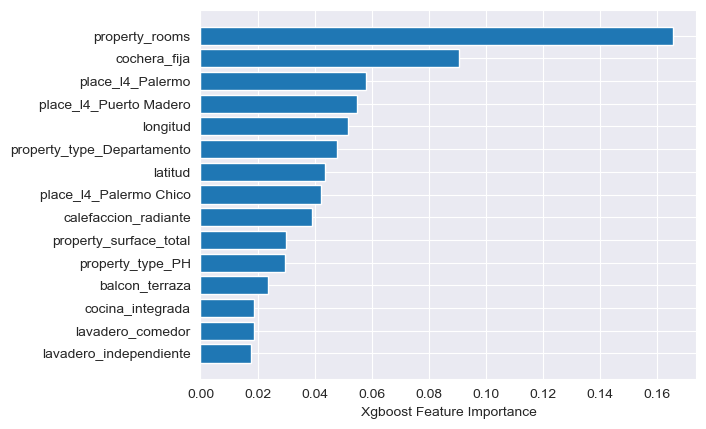

In [104]:
sorted_idx = XGB_Regressor.feature_importances_.argsort()
sorted_idx = sorted_idx[-15:]
plt.barh(df_test_dummies.columns[sorted_idx], XGB_Regressor.feature_importances_[sorted_idx])
a = plt.xlabel("Xgboost Feature Importance")

Podemos observar que el feature más importante es la ubicación es la cantidad de habitaciones, seguido de cantidad de la cochera fija y ubicación en Palermo.

### Importancia de features por aspecto agregado en el punto 1.a

Aspecto Cocina

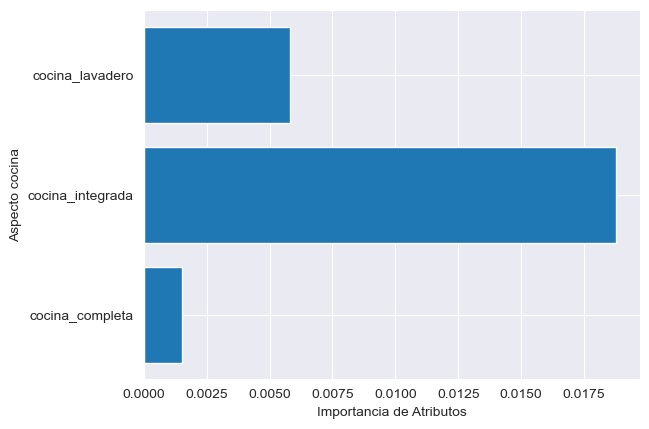

In [105]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('cocina_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto cocina")

Aspecto Pisos

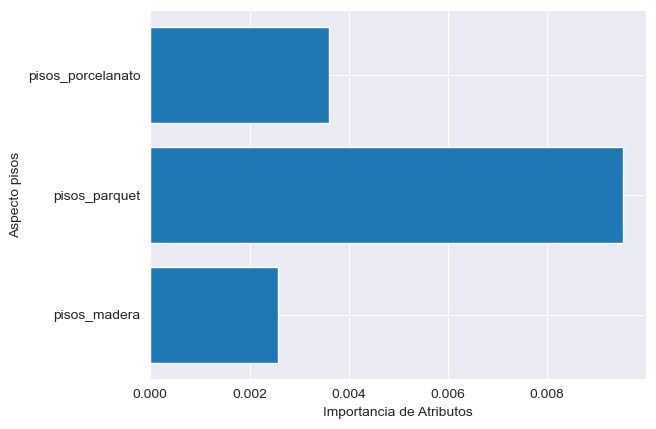

In [106]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('pisos_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto pisos")

Aspecto Calefaccion

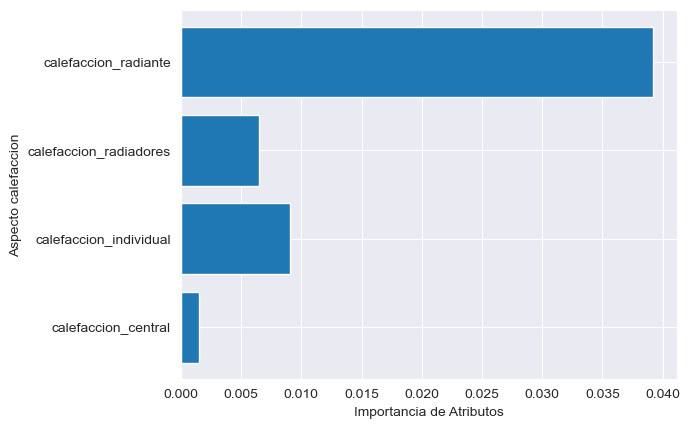

In [107]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('calefaccion_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto calefaccion")

Aspecto Expensas

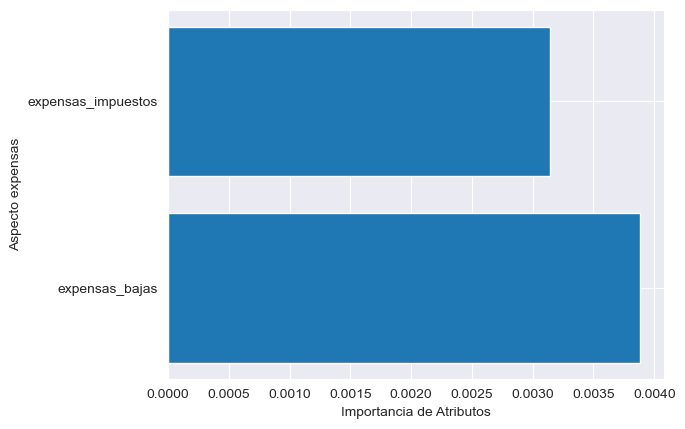

In [108]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('expensas_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto expensas")

Aspecto Lavadero

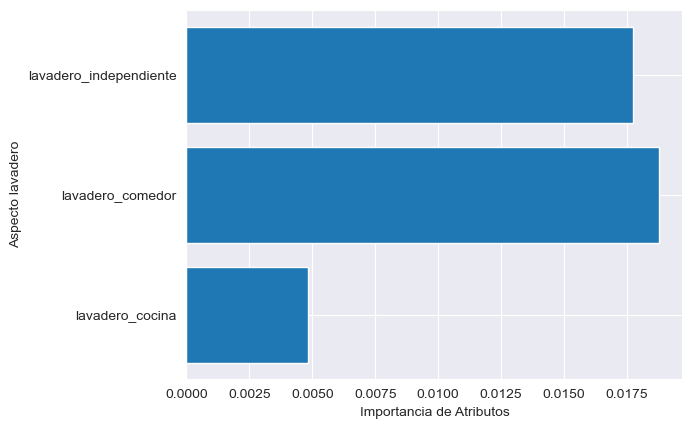

In [109]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('lavadero_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto lavadero")

Aspecto Balcon

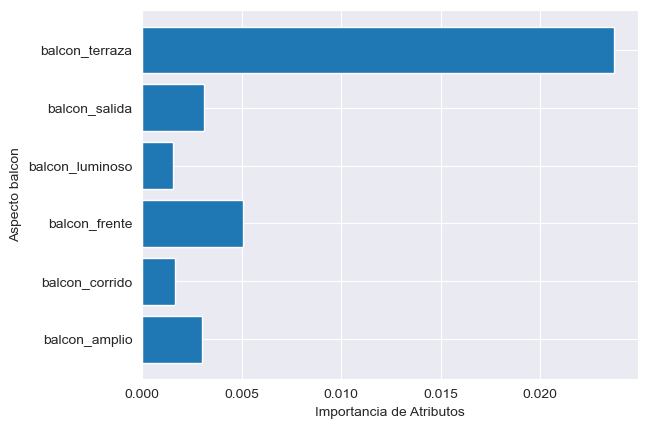

In [110]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('balcon_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto balcon")

Aspecto Cochera

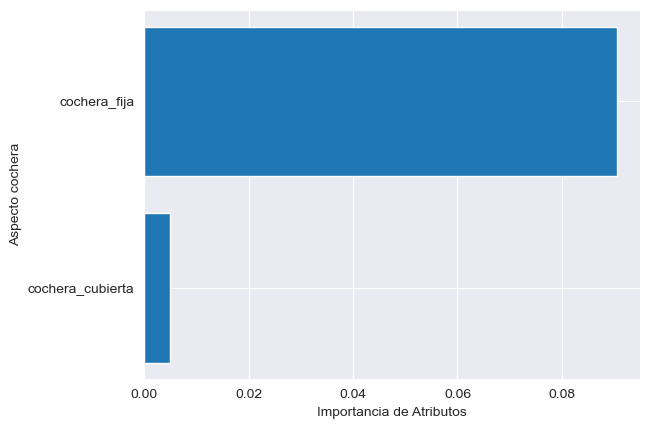

In [111]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('cochera_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto cochera")

Aspecto Aire

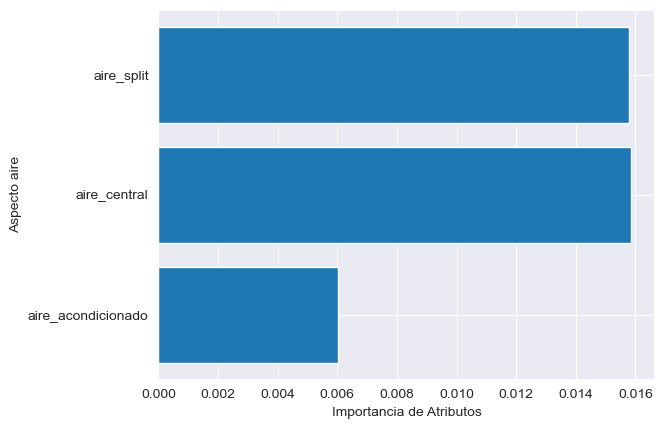

In [112]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('aire_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto aire")

## Con optimización de hiperparámetros

Veamos cómo se comporta el score con la optimización de hiperparámetros:

In [113]:
params_grid = {'learning_rate': [0.20, 0.25, 0.30],
               'max_depth': [4, 6, 8, 10],
               'min_child_weight': [1, 3, 5, 7, 9],
               'gamma': [0.1, 0.3, 0.5],
               'colsample_bytree' : [0.3, 0.5, 0.7]}

randomCV = RandomizedSearchCV(estimator = XGBRegressor(),
                              param_distributions = params_grid,
                              scoring = make_scorer(r2_score),
                              cv = 5,
                              n_iter = 20)

randomCV.fit(df_dummies, df_train_y_regresion)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7],
                                        'gamma': [0.1, 0.3, 0.5],
                                        'learning_rate': [0.2, 0.25, 0.3],
                                        'max_depth': [4, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring=make_scorer(r2_score))

In [114]:
randomCV.best_params_

{'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 0.3,
 'gamma': 0.1,
 'colsample_bytree': 0.3}

In [115]:
prediccion_y_metricas_regresion(randomCV.best_estimator_,df_test_dummies, df_test_y_regresion)

Se obtuvo un Score de 57.964%
La métrica 'Mean Square Error' de test es: 53091896539.97901
La métrica 'Root Mean Square Error' de test es: 230416.7887545936


Observamos que, si bien las métricas mejoraron, las diferencias al optimizar los parámetros no fueron muy significativas.

### Importancia de features
Graficamos los 15 features más importantes para el modelo con los hiperparámetros optimizados

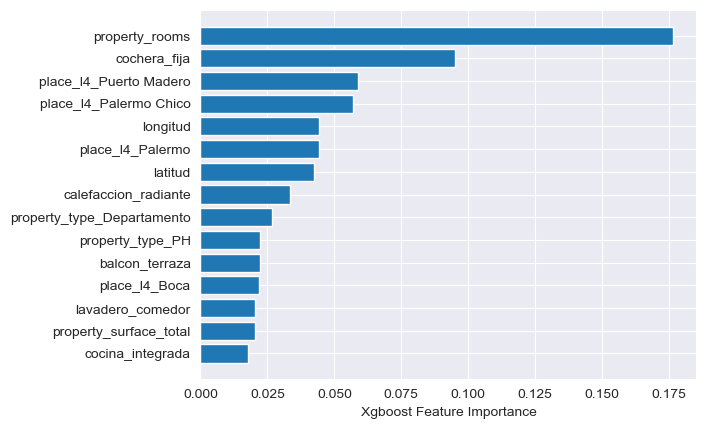

In [116]:
sorted_idx = randomCV.best_estimator_.feature_importances_.argsort()
sorted_idx = sorted_idx[-15:]
plt.barh(df_test_dummies.columns[sorted_idx], randomCV.best_estimator_.feature_importances_[sorted_idx])
a = plt.xlabel("Xgboost Feature Importance")

Podemos ver que la ubicación en Puerto Madero tiene más peso que en el modelo anterior. Cochera fija sigue siendo un feature importante, pero menos que anteriormente. La cantidad de habitaciones tiene mayor peso que el modelo anterior.

### Importancia de features por aspecto agregado en el punto 1.a

Aspecto Cocina

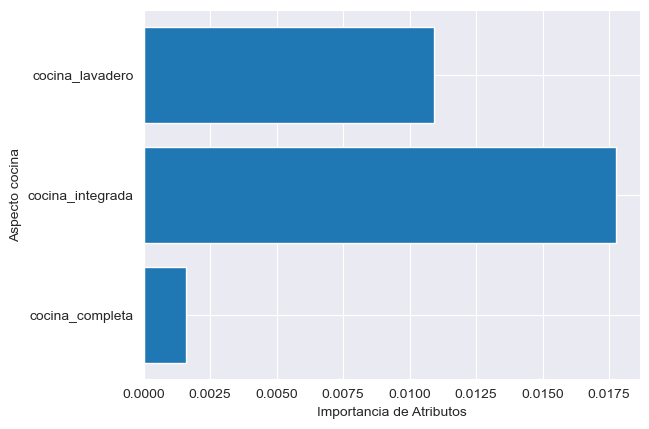

In [117]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('cocina_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto cocina")

Aspecto Pisos

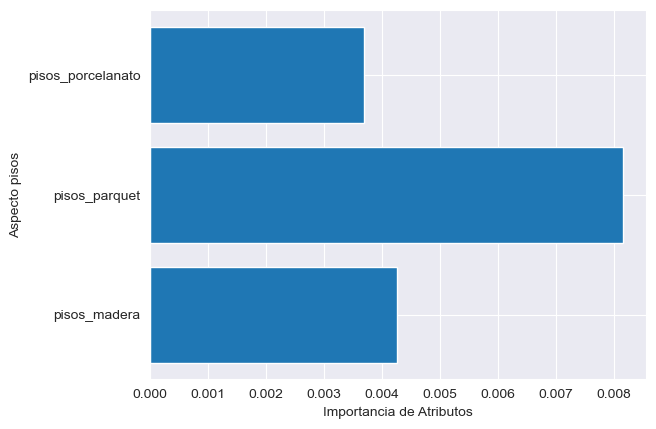

In [118]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('pisos_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto pisos")

Aspecto Calefaccion

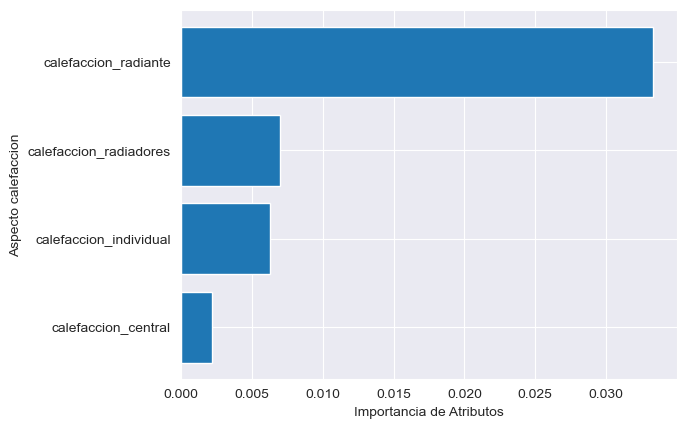

In [119]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('calefaccion_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto calefaccion")

Aspecto Expensas

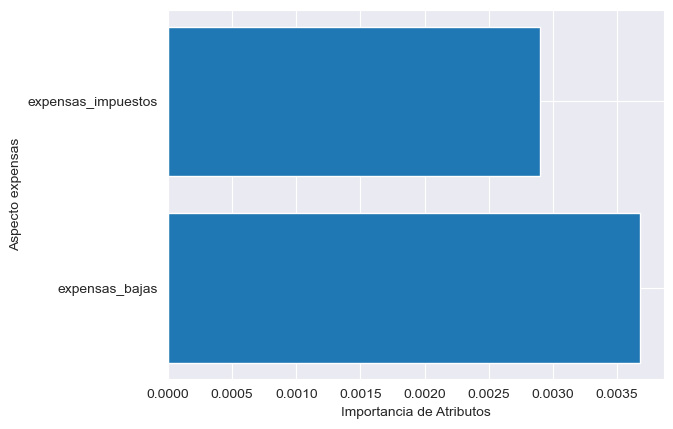

In [120]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('expensas_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto expensas")

Aspecto Lavadero

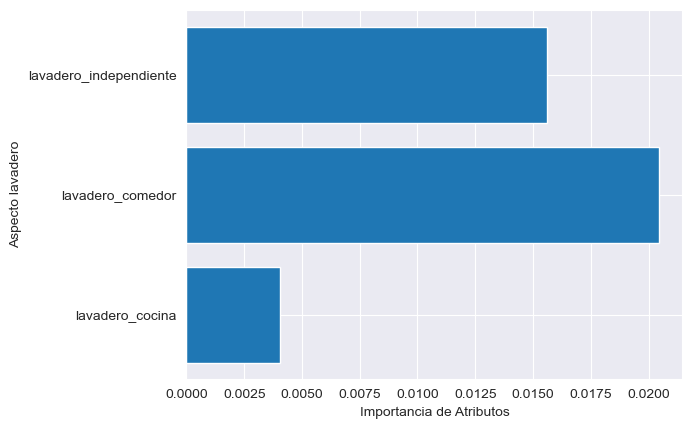

In [121]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('lavadero_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto lavadero")

Aspecto Balcon

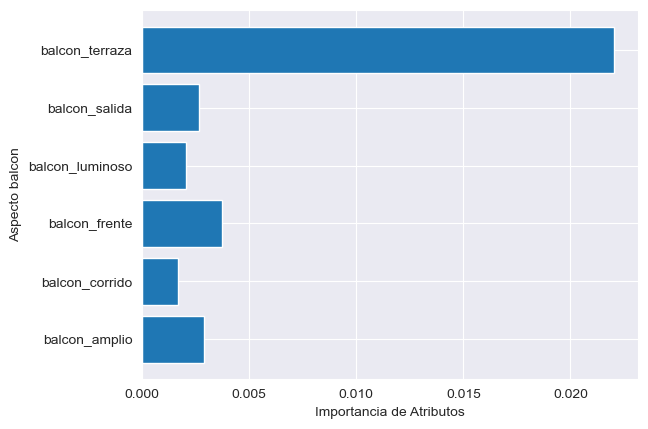

In [122]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('balcon_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto balcon")

Aspecto Cochera

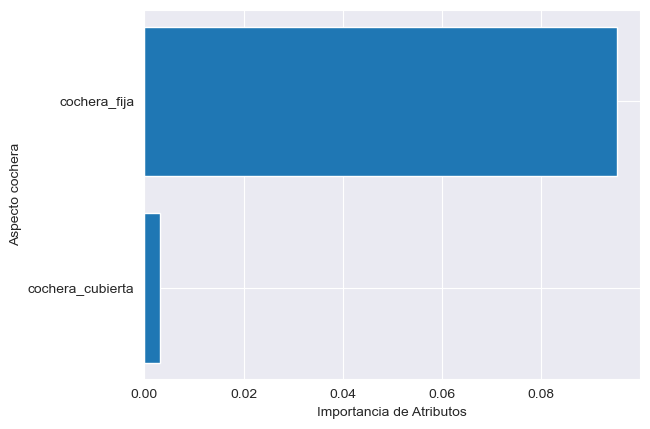

In [123]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('cochera_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto cochera")

Aspecto Aire

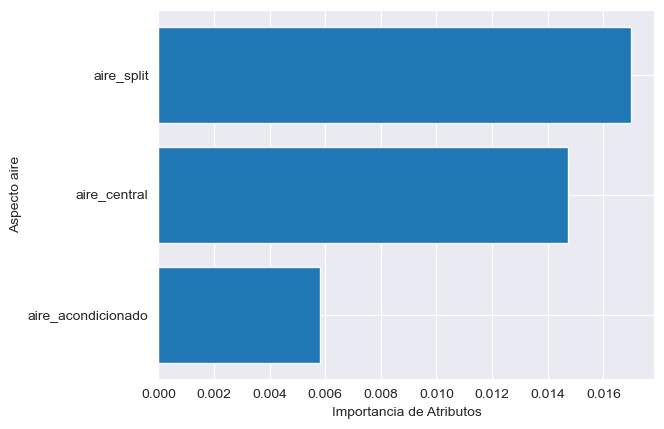

In [124]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('aire_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto aire")

#### Exportación del Modelo
Finalmente exportamos el modelo utilizado para predecir, resultante de la optimización de hiperparámetros:

In [125]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/XGB_Regressor.json'
else:
  path = './MODELOS/XGB_Regressor.json'

randomCV.best_estimator_.save_model(path)

## 2. Redes Neuronales

### 2.a Regresión

#### 2.a.1 Preparación del dataset

In [13]:
x_train_regresion = df_train_x.drop(["id"], axis=1).copy()
y_train_regresion = df_train_y_regresion.copy()
x_test_regresion = df_test_x.drop(["id"], axis=1).copy()
y_test_regresion = df_test_y_regresion.copy()

Normalizamos las entradas con StandardScaler:

In [14]:
x_train_regresion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_train_regresion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

x_test_regresion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_test_regresion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

#### 2.a.2 Búsqueda del mejor modelo

Creo una función que me permite generar un modelo a partir de sus hiperparámetros. Esta función tiene como parámetros la cantidad de nodos de la primera y anteúltima capa, la cantidad de capas ocultas, la función de activación y el optimizador. Todos los modelos que genera a excepción de los casos sin capas ocultas) tienen forma de 'pirámide'.

In [15]:
cantidad_de_columnas = x_train_regresion.shape[1]

def crear_modelo(hidden_layers, first_layer_nodes, last_layer_nodes, activation_func, optimizer):

    sequential = Sequential()
    sequential.add(keras.layers.Dense(first_layer_nodes, input_shape=(cantidad_de_columnas,), activation='relu'))

    if hidden_layers is 0 or hidden_layers is 1:
        decremento = 0
    else:
        decremento = math.ceil((first_layer_nodes - last_layer_nodes) / (hidden_layers - 1))

    for i in range (0, hidden_layers):
        nodos = first_layer_nodes - decremento * i
        sequential.add(Dense(nodos, activation=activation_func))

    sequential.add(Dense(1, activation='linear'))

    sequential.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mse', 'mean_absolute_percentage_error']
    )

    return sequential


modelo =  KerasRegressor(build_fn=crear_modelo, verbose = False)

Luego busco el mejor modelo a partir de una grilla de parámetros arbitrarios con el método de 'GridSearchCV'. El criterio de mejor modelo es el que tenga menor error cuadrado, o lo que es equivalente, mayor error cuadrado negado. Nos limitamos en la cantidad de folds en el CV por el consumo temporal.

In [16]:
param_grid = dict(
    hidden_layers=[2, 4],
    first_layer_nodes = [x_train_regresion.shape[1], math.ceil(cantidad_de_columnas * (2/3))],
    last_layer_nodes = [5],
    activation_func = ['sigmoid', 'relu'],
    batch_size = [750],
    epochs = [70],
    optimizer=['RMSprop'],
)

grid = GridSearchCV(
    estimator = modelo,
    param_grid = param_grid,
    cv=5,
    error_score='raise',
    scoring='neg_mean_squared_error',
    verbose=0,
)

Entrenamos todos los modelos

In [17]:
grid.fit(x_train_regresion, y_train_regresion)

GridSearchCV(cv=5, error_score='raise',
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f4b0ab69df0>,
             param_grid={'activation_func': ['sigmoid', 'relu'],
                         'batch_size': [750], 'epochs': [70],
                         'first_layer_nodes': [69, 46], 'hidden_layers': [2, 4],
                         'last_layer_nodes': [5], 'optimizer': ['RMSprop']},
             scoring='neg_mean_squared_error')

Guardamos el historial de entrenamiento del mejor modelo

In [18]:
history = grid.best_estimator_.model.history.history

Los parámetros y métricas del mejor modelo fueron:

In [19]:
print("El error absoluto porcentual promedio del mejor modelo fue de: ", grid.best_estimator_.model.metrics[2].result().numpy())
print("El error absoluto cuadrado promedio del mejor modelo fue de: ", grid.best_estimator_.model.metrics[1].result().numpy())
print("Los parámetros seleccionados por Grid search 5-fold cross validation fueron: ", grid.best_params_)

El error absoluto porcentual promedio del mejor modelo fue de:  65.52518
El error absoluto cuadrado promedio del mejor modelo fue de:  51179336000.0
Los parámetros seleccionados por Grid search 5-fold cross validation fueron:  {'activation_func': 'relu', 'batch_size': 750, 'epochs': 70, 'first_layer_nodes': 69, 'hidden_layers': 4, 'last_layer_nodes': 5, 'optimizer': 'RMSprop'}


#### 2.a.3 Predicción

In [20]:
y_pred = grid.predict(x_test_regresion)

#### 2.a.4 Métricas

Veamos cómo se comporta la función de pérdida del mejor modelo según la cantidad de épocas utilizadas:

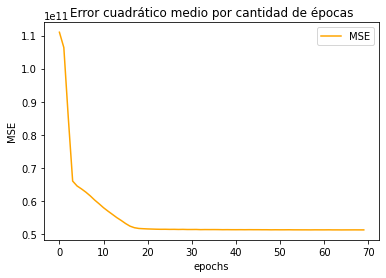

In [21]:
epochs = range(70)
plt.plot(epochs, history['mse'], color='orange', label='MSE')
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title('Error cuadrático medio por cantidad de épocas')
plt.legend()

In [34]:
mse = metrics.mean_squared_error(
    y_true  = y_test_regresion,
    y_pred  = y_pred,
    squared = True
)

print(f"La métrica 'Mean Square Error' de test es: {mse}")

rmse = metrics.mean_squared_error(
    y_true  = y_test_regresion,
    y_pred  = y_pred,
    squared = False
)

print(f"La métrica 'Root Mean Square Error' de test es: {rmse}")

El error según la métrica 'Mean Square Error' de test es: 107144176406.78777
El error según la métrica 'Root Mean Square Error' de test es: 327328.85055672645


#### 2.a.5 Exportación de Datos

Finalmente, exportamos el modelo utilizado:

In [ ]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/Redes_Regressor.joblib'
else:
  path = './MODELOS/Redes_Regressor.joblib'

joblib.dump(grid.best_estimator_.model, path)

### 2.b Clasificación
___

#### 2.b.1 Preparación del dataset

In [23]:
x_train_clasificacion = df_train_x.drop(["id"], axis=1).copy()
y_train_clasificacion = df_train_y_clasificacion.copy()
x_test_clasificacion = df_test_x.drop(["id"], axis=1).copy()
y_test_clasificacion = df_test_y_clasificacion.copy()

Normalizamos mediante Z-Score:

In [24]:
x_train_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_train_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

x_test_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_test_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

Aplicamos One Hot encoding a la columna target de entrenamiento y test, para que tenga 3 columnas al igual que la salida del modelo:

In [25]:
y_train_clasificacion = pd.get_dummies(y_train_clasificacion, columns=['tipo_precio_3'], drop_first=False)
y_test_clasificacion = pd.get_dummies(y_test_clasificacion, columns=['tipo_precio_3'], drop_first=False)

#### 2.b.2 Búsqueda del mejor modelo

Función auxiliar para que GridSearchCV realice el scoring de forma correcta.

In [26]:
def my_categorical_accuracy(y_true, y_pred) :
    y_pred_df = pd.DataFrame(data=y_pred, columns=['alto', 'bajo', 'medio'])
    res = round(accuracy_score(y_true, y_pred_df), 2)
    return res

Creamos una función que permite generar un modelo a partir de sus hiperparámetros configurables.
Esta función recibe como parámetros la cantidad de capas ocultas extra, la cantidad de nodos de la última capa oculta, la función de activación y metadata del clasificador.

In [27]:
def crear_modelo(extra_hidden_layers, last_layer_nodes, activation_func, loss_func, meta):

    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]

    sequential = Sequential()
    sequential.add(keras.layers.Dense(n_features_in_ * 0.7, input_shape=X_shape_[1:], activation='relu'))

    if last_layer_nodes > n_features_in_:
        decremento = 0
    elif extra_hidden_layers is 0 or extra_hidden_layers is 1:
        decremento = 0
    else:
        decremento = math.ceil((n_features_in_ - last_layer_nodes) / (extra_hidden_layers - 1))

    for i in range (0, extra_hidden_layers):
        nodos = n_features_in_ - decremento * i
        sequential.add(Dense(nodos, activation=activation_func))

    sequential.add(Dense(n_classes_, activation='softmax'))

    sequential.compile(
        loss=loss_func
    )

    return sequential


Creamos un modelo base, necesario según la documentación de SciKeras - KerasClassifier.
Este modelo base será editado por GridSearchCV al buscar los hiperparámetros.

In [28]:
base_model = KerasClassifier(
    crear_modelo,
    loss_func="categorical_crossentropy",
    extra_hidden_layers=1,
    last_layer_nodes=1,
    activation_func='sigmoid',
)

Definimos los hiperparámetros posibles. Además de los necesarios por la función crear_modelo, agregamos diferentes optimizadores, learning rates y cantidad de épocas.

In [29]:
param_grid = dict(
    extra_hidden_layers=[1, 4],
    last_layer_nodes = [5, 10, 20],
    activation_func = ['relu', 'softmax'],
    batch_size = [750],
    epochs = [20],
    optimizer__learning_rate = [0.001],
    optimizer = ["adam", "sge"],
    loss_func = ["categorical_crossentropy"],
)

gs = GridSearchCV(base_model,
                  param_grid = param_grid,
                  cv=5,
                  scoring=make_scorer(my_categorical_accuracy),
                  verbose=0,
                  error_score='raise'
)

Entrenamos los diferentes modelos y obtenemos los mejores parámetros.

In [ ]:
gs.fit(x_train_clasificacion, y_train_clasificacion)
print("Los parámetros óptimizados fueron: ", gs.best_params_)

Predecimos con el dataset de test

In [31]:
y_pr = gs.predict(x_test_clasificacion)

25/25 [==============================] - 0s 6ms/step


#### 2.b.4 Métricas
Transformamos el array devuelto por el modelo a un dataframe de iguales columnas que y_test_clasificacion

In [32]:
y_pr_df = pd.DataFrame(data=y_pr, columns=['alto', 'bajo', 'medio'])

Calculamos las métricas

In [33]:
metricas_clasificacion(y_test_clasificacion, y_pr_df)

Accuracy: 0.57
Precision: 0.58
Recall: 0.5
F1 Score: 0.51


#### 2.b.5 Exportación de Datos

Finalmente, exportamos el modelo utilizado:

In [ ]:
import joblib

if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/Redes_Classifier.joblib'
else:
  path = './MODELOS/Redes_Classifier.joblib'

joblib.dump(gs.best_estimator_, path)

## 3. Ensamble de Modelos

### 3. a) Voting - Clasificación
___

#### Preparación del dataset

Para la parte de ensambles, lo que haremos será utilizar nuevamente el dataset al cual se le aplicó una reducción de su dimensionalidad en el trabajo práctico n°1.

Para esto lo que haremos será trabajar con una copia del dataset modificado al inicio del trabajo, el cual usa como base el reducido mencionado anteriormente.

Para nuestra variable `target`, utilizaremos como convención la misma que fue planteada para el tp1. Ésta consiste en subdividir a la variable pxm2 (precio por metro cuadrado) en 3 intervalos, 25% a bajo, 50% a medio y el otro 25% restante a alto. A su vez, se hará la separación tambien por tipo de propiedad.

In [35]:
x_train_voting = df_train_x.drop(["id"], axis=1).copy()
y_train_voting = df_train_y_clasificacion.copy()
x_test_voting = df_test_x.drop(["id"], axis=1).copy()
y_test_voting = df_test_y_clasificacion.copy()

x_train_voting[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_train_voting[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

x_test_voting[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_test_voting[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

y_train_voting = pd.get_dummies(y_train_voting, columns=['tipo_precio_3'], drop_first=False)
y_test_voting = pd.get_dummies(y_test_voting, columns=['tipo_precio_3'], drop_first=False)

In [36]:
bajo = y_train_voting['bajo'].sum() + y_test_voting.bajo.sum()
medio = y_train_voting['medio'].sum() + y_test_voting.medio.sum()
alto = y_train_voting['alto'].sum() + y_test_voting.alto.sum()

print(f"Se observaron:")
print(f"- {round(bajo,3)} registros de tipo 'bajo'.")
print(f"- {round(medio,3)} registros de tipo 'medio'.")
print(f"- {round(alto,3)} registros de tipo 'alto'.")

Se observaron:
- 23227 registros de tipo 'bajo'.
- 46459 registros de tipo 'medio'.
- 23170 registros de tipo 'alto'.


#### Definición del Ensamble

Para el tipo de ensamble **voting**, lo que necesitaremos será contar con `n` cantidad de modelos previamente entrenados para luego someterlos a una votación. De la misma, saldrá la clasificación para la nueva instancia en base a lo que indique la mayoría de ellos.

Elegimos tomar como modelos los mismos empleados en el TP1:


*   Árbol de Decisión
*   Random Forest
*   KNN



En esta línea, cargamos en memoria los modelos previamente guardados:

In [40]:
if IN_COLAB:
  path = '/content/drive/MyDrive/Orga/MODELOS/DecisionTree_Classifier.joblib'
else:
  path = './MODELOS/DecisionTree_Classfier.joblib'

dcs_clf = load(path)

In [41]:
if IN_COLAB:
  path = '/content/drive/MyDrive/Orga/MODELOS/RandomForest_Classifier.joblib'
else:
  path = './MODELOS/RandomForest_Classfier.joblib'

rnd_clf = load(path)

In [42]:
if IN_COLAB:
  path = '/content/drive/MyDrive/Orga/MODELOS/KNN_Classifier.joblib'
else:
  path = './MODELOS/KNN_Classfier.joblib'

knn_clf = load(path)

Recordemos que estos modelos fueron optimizados con los siguientes hiperparámetros y valores:

- **Decision Tree**:
    * ccp_alpha: 0.0001
    * criterion: gini
    * max_depth: 21
- **Random Forest**:
    * ccp_alpha: 0.0001
    * criterion: entropy
    * max_depth: 25
    * n_estimators: 55
- **K Nearest Neighbors**:
    * algorithm: kd_tree
    * leaf_size: 5
    * n_jobs: -1
    * n_neighbors: 3
    * weights: distance

Una vez que contamos con los modelos que vamos a utilizar en el ensamble, procedemos a su creación. En este caso particular decidimos utilizar el tipo de votación `hard` el cual utilizará la regla de la mayoría. Por otro lado, utilizamos el hiperparámetro `estimators` para definir como nos vamos a referir a dichos modelos.

In [43]:
vot_clf = VotingClassifier(estimators = [('dcs', dcs_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#### Entrenamiento y Predicción

Reorganizamos los valores predichos para que queden en una sola columna. Luego, procedemos a comparar con el conjunto de prueba:

In [44]:
y_train_voting_arr = np.apply_along_axis(convert_b_m_a, axis=1, arr=y_train_voting)

Seguimos reacomodando los valores para poder calcular las métricas correspondientes, notemos que no pueden guardarse valores equivalentes al string 'medio' en el array:

In [45]:
np.unique(y_train_voting_arr)

array(['alto', 'bajo', 'medio'], dtype='<U5')

Aplicamos estrategias de transformación de datos:

In [46]:
y_train_voting_arr = np.where(y_train_voting_arr == 'medi', 'medio', y_train_voting_arr)

In [47]:
np.unique(y_train_voting_arr)

array(['alto', 'bajo', 'medio'], dtype='<U5')

Finalmente, `entrenamos` el ensamble:

In [48]:
vot_clf.fit(x_train_voting, y_train_voting_arr)

VotingClassifier(estimators=[('dcs',
                              DecisionTreeClassifier(ccp_alpha=0.0001,
                                                     max_depth=21)),
                             ('rnd',
                              RandomForestClassifier(ccp_alpha=0.0001,
                                                     criterion='entropy',
                                                     max_depth=25,
                                                     n_estimators=55,
                                                     random_state=5)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   leaf_size=5, n_jobs=-1,
                                                   n_neighbors=3,
                                                   weights='distance'))])

In [49]:
y_pred_voting = vot_clf.predict(x_test_voting)

Reaplicamos la reorganización de valores para el dataset de test:

In [50]:
y_test_voting_arr = np.apply_along_axis(convert_b_m_a, axis=1, arr=y_test_voting)

In [51]:
np.unique(y_test_voting_arr)

array(['alto', 'bajo', 'medio'], dtype='<U5')

#### Métricas

Para poder determinar que tan bueno resulto el modelo, lo que haremos será observar las `métricas` resultantes de una predicción con los datos de test. Recordemos que nuestras funciones de metricas fueron definidas al inicio de este trabajo.

In [52]:
metricas_clasificacion(y_test_voting_arr, y_pred_voting)

Accuracy: 0.63
Precision: 0.65
Recall: 0.57
F1 Score: 0.59


Como se puede observar, el ensamble resultante predice bastante bien, aunque podriamos obtener mejores métricas. Si bien el Accuracy y la precision son buenas, al momento de calcular el recall tenemos un valor un poco menor, el cual repercute directamente en el F1 Score ya que como sabemos este tiene en cuenta las métricas tanto de Precision como Recall.

A su vez, también podemos visualizar los mismos a través de la siguiente matriz de confusión.

Text(33.0, 0.5, 'True')

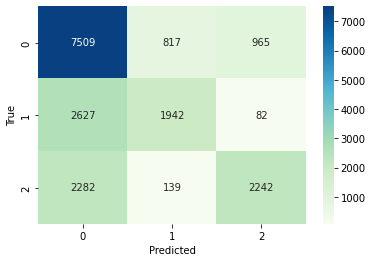

In [53]:
matrix = confusion_matrix(y_test_voting_arr, y_pred_voting)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Nuevamente aqui se puede observar que la celda que presenta mayores valores por una amplia diferencia es la `[0][0]`. Notemos que las que le siguen en cantidad se ubican en `[1][0]` y `[2][0]`, las cuales hacen que las métricas decrementen su valor. Cercano a estos valores esta la celda de `[2][2]` en donde volvemos a tener saldo positivo, al igual que cuando tenemos en cuenta la `[1][1]` que por mas que sean algunos registros menos, sigue siendo una cantidad significante. Concluimos luego que los resultados se correlacionan con la matríz de confusión.

#### Exportación de Datos

Finalmente, exportamos el ensamble utilizado:

In [54]:
if IN_COLAB:
  path = '/content/drive/MyDrive/Orga/MODELOS/Voting_Classifier.joblib'
else:
  path = './MODELOS/Voting_Classifier.joblib'

dump(vot_clf, path)

['/content/drive/MyDrive/Orga/MODELOS/Voting_Classifier.joblib']

### 3. b) Stacking - Regresión
___

#### Preparación del dataset

Nuevamente, utilizamos los datasets de train y test previamente definidos:

In [30]:
x_train_stacking = df_train_x.drop(["id"], axis=1).copy()
y_train_stacking = df_train_y_regresion.copy()
x_test_stacking = df_test_x.drop(["id"], axis=1).copy()
y_test_stacking = df_test_y_regresion.copy()

x_train_stacking[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_train_stacking[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

x_test_stacking[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_test_stacking[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

#### Definición del Ensamble


Lo que haremos en esta nueva sección, será implementar un nuevo tipo de ensable híbrido con la salvedad de que esta vez utilizaremos el tipo `cascading`.
El mismo se basa en el entrenamiento de distintos `modelos base`, y a su vez utilizará un `meta-modelo` el cual realizará su predicción en base a las predicciones de los diferentes modelos comentados anteriormente.

Como es indicado por el enunciado del trabajo se utilizarán modelos de regresión. En particular, decidimos trabajar con:


*   KNN
*   XGBoost
*   AdaBoost



En esta línea, cargamos en memoria los modelos previamente guardados del TP1 realizado con anterioridad:

In [31]:
if IN_COLAB:
  path = '/content/drive/MyDrive/Orga/MODELOS/KNN_Regressor_Train.joblib'
else:
  path = './MODELOS/KNN_Regressor_Train.joblib'

knn_rgs = load(path)

In [32]:
if IN_COLAB:
  path = '/content/drive/MyDrive/Orga/MODELOS/XGB_Regressor_Train.joblib'
else:
  path = './MODELOS/XGB_Regressor_Train.joblib'

xgb_rgs = load(path)

[22:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
if IN_COLAB:
  path = '/content/drive/MyDrive/Orga/MODELOS/AdaB_Regressor_Train.joblib'
else:
  path = './MODELOS/AdaB_Regressor_Train.joblib'

adb_rgs = load(path)

A modo de recordatorio, enunciamos los hiperparámetros con los que estos modelos fueron optimizados:

- **K Nearest Neighbors**:
    * weights: uniform
    * n_neighbors: 51
    * metric: chebyshev
    * leaf_size: 22
    * algorithm: ball_tree
- **Extreme Gradient Boosting**:
    * min_child_weight: 5
    * max_depth: 6
    * learning_rate: 0.3
    * gamma: 0.1
    * colsample_bytree: 0.3
- **Adaptive Boosting**:
    * n_estimators: 10
    * learning_rate: 1.02

Luego utilizamos los mismos para definir nuestro modelo base, en el cual luego se basará el meta-modelo.

In [34]:
base_models = [('KNN', knn_rgs),
               ('XGBoost', xgb_rgs),
               ('AdaBoost', adb_rgs)]

Como mencionamos, a continuación los utilizaremos para definir nuestro meta-modelo. Para este último, decidimos emplear el modelo de regresión logistica.

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

meta_model = GradientBoostingRegressor()

Creamos nuestro ensamble indicando como modelos estimadores Knn, XGBoost y AdaBoost, y como estimador final el modelo de Regresión Lineal.

In [36]:
s = 5
n = 2

In [37]:
stacking_model = StackingRegressor(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=s,
                                    verbose=n)

#### Entrenamiento y Predicción

Una vez conformado el ensamble que decidimos utilizar, ahora si estamos en condiciones de pasar a realizar su entrenamiento.

In [38]:
model_scores = defaultdict()

for name, model in base_models:
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_test_stacking, y_test_stacking, s, n)
    model_scores[name] = scores

Evaluating KNN


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   57.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   15.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.3s finished


Una vez que realizamos una iteración por cada uno de los modelos base, evaluamos cómo resultaron los scores de los mismos a través del siguiente gráfico. En éste se puede apreciar la relación de cada uno de los modelos, y a su vez tener una noción concreta de sus principales métricas (mediana, q1, q3, mánimo y máximo).

In [39]:
plot_results(model_scores, name='stacking_model_cv')

Entrenamos el modelo:

In [40]:
stacking_model.fit(x_train_stacking, y_train_stacking)

[22:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[22:38:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[22:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.8s finished


StackingRegressor(cv=5,
                  estimators=[('KNN',
                               KNeighborsRegressor(algorithm='ball_tree',
                                                   leaf_size=18,
                                                   metric='manhattan',
                                                   n_neighbors=1)),
                              ('XGBoost',
                               XGBRegressor(colsample_bytree=0.3, gamma=0.1,
                                            learning_rate=0.3, max_depth=6,
                                            min_child_weight=5, missing=nan)),
                              ('AdaBoost',
                               AdaBoostRegressor(learning_rate=1.03,
                                                 n_estimators=8))],
                  final_estimator=GradientBoostingRegressor(), passthrough=True,
                  verbose=2)

Finalmente haremos la predicción:

In [41]:
y_pred_stacking = stacking_model.predict(x_test_stacking)

#### Métricas

Para poder evaluar la performance que obtuvo nuestro modelo utilizaremos la métrica de evaluación del `error cuadrático medio` (MSE) como se pide por enunciado.

In [45]:
mse = metrics.mean_squared_error(
    y_true  = y_test_stacking,
    y_pred  = y_pred_stacking,
    squared = True
)

print(f"La métrica 'Mean Square Error' de test es: {mse}")

rmse = metrics.mean_squared_error(
    y_true  = y_test_stacking,
    y_pred  = y_pred_stacking,
    squared = False
)

print(f"La métrica 'Root Mean Square Error' de test es: {rmse}")

r2 = metrics.r2_score(
    y_true  = y_test_stacking,
    y_pred  = y_pred_stacking
)

print(f"La métrica 'R2 Score' de test es: {r2}")

La métrica 'Mean Square Error' de test es: 74468989103.93723
La métrica 'Root Mean Square Error' de test es: 272890.0678000891
La métrica 'R2 Score' de test es: 0.41038471426711143


#### Exportación de Datos

Finalmente, exportamos el modelo utilizado:

In [29]:
if IN_COLAB:
  path = '/content/drive/MyDrive/Orga/MODELOS/Stacking_Regressor.joblib'
else:
  path = './MODELOS/Stacking_Regressor.joblib'

dump(stacking_model, path)

['/content/drive/MyDrive/Orga/MODELOS/Stacking_Regressor.joblib']

## Conclusiones

A modo de finalización de este trabajo, haremos un pequeño repaso sobre todos los puntos que analizamos y sus respectivos resultados y/o observaciones hechos por nosotros:

Sobre el análisis realizado en el apartado de **procesamiento del lenguaje natural**, y en particular haciendo referencia a las métricas que obtuvimos luego del entrenamiento y predicción con el dataset producto de la ampliación, utilizando el modelo XGBoost, pudimos observar que si bien aún las métricas no nos resultan del todo satisfactorias cumplen con el objetivo de mejorar las resultantes del trabajo anterior. Más allá de que la cantidad de aciertos continúa sin incrementar, tanto el MSE como el RMSE decrecieron ofreciendo mejores resultados. Por otro lado, el coeficiente de determinación se incrementó notoriamente llegando casi a un 0.9%. En lo que respecta a *feature importance*, realizamos la misma enfocándonos en los atributos de cada uno de los aspectos elegidos como más importantes del dataset general. Cabe destacar que obtuvimos los mismos resultados con y sin optimizar los hiperparámetros del modelo de regresión.

En cuanto a lo referido sobre **redes neuronales**, la comparación será directamente en base a los nuevos modelos ya que el dataset utilizado es compartido en ambos trabajos. Dicho esto, el error cometido en el modelo de regresión es significativamente pequeño. Teniendo en cuenta los resultantes del TP1, si utilizamos el menor luego de que éstos tuvieron su optimización de parámetros correspondiente, notamos que el que mejor performa es XGBoost con un MSE de 51 mil millones (al cual de todas formas le atribuímos arrastre de error en nuestro planteo). Utilizando redes neuronales cometemos tan solo un error cuadrático medio equivalente a 1.36. Por otro lado, en lo que respecta al modelo de clasificación, obtuvimos resultados bastante similares. Si bien tanto el accuracy, precisión y F1-Score dieron distintos, la diferencia es de tan solo uno/dos puntos. Con esto concluimos que para clasificación no se notan mejoras por sobre los modelos utilizados en el trabajo anterior.

Como último requerimiento se pidió estudiar las métricas tanto para regresión como clasificación pero haciendo uso de **ensambles**, en particular de tipo híbridos. En lo que respecta al utilizado para clasificación (Voting) obtuvimos mejores resultados para las métricas de Accuracy, Recall y F1-Score. Sin embargo, aunque en Precisión disminuyó un poco, esta diferencia continúa siendo no significativa. Pasando al ensamble de regresión (Stacking) el MSE resultante que obtuvimos fue 106 mil millones que si bien continúa siendo alto, luego de aplicar la optimización de hiperparámetros como nos fue recomendado como corrección de esta reentrega este número se redujo a la mitad que obtenido en la entrega inicial. Mas allá de esto, al continuar siendo este bastante grosero, creemos que nuevamente estamos cometiendo involuntariamente algún arrastre de error en alguno de los incisos desarrollados, ya que este error es incluso mayor a los cometidos en los modelos individuales desarrollados en el TP1, y no estaría respetando la regla principal de ‘*La sabiduría de las multitudes*’.